In [1]:
import pandas as pd

try:
    train_df = pd.read_csv('train_v9rqX0R.csv')
    test_df = pd.read_csv('test_AbJTz2l.csv')
    display(train_df.head())
    display(test_df.head())
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found.")
except pd.errors.ParserError:
    print("Error: There was an issue parsing the CSV file(s).")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [2]:
print(f"{train_df.shape}")
print(f"{test_df.shape}")

(8523, 12)
(5681, 11)


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [3]:
# Check missing values
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()
print(f"{missing_train}")
print(f"{missing_test}")

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64
Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


In [4]:
# Step 2: Data Cleaning and Missing Value Imputation

# Make copies to preserve originals
train_cleaned = train_df.copy()
test_cleaned = test_df.copy()

# 1. Impute Item_Weight
# We can impute by mean weight of each Item_Identifier (better than overall mean)
item_weight_mean = train_cleaned.pivot_table(values='Item_Weight', index='Item_Identifier')

def impute_item_weight(cols):
    Item_Weight = cols[0]
    Item_Identifier = cols[1]
    if pd.isnull(Item_Weight):
        if Item_Identifier in item_weight_mean.index:
            return item_weight_mean.loc[Item_Identifier].values[0]
        else:
            return train_cleaned['Item_Weight'].mean()  # fallback
    else:
        return Item_Weight

# Apply to train and test
train_cleaned['Item_Weight'] = train_cleaned[['Item_Weight', 'Item_Identifier']].apply(impute_item_weight, axis=1)
test_cleaned['Item_Weight'] = test_cleaned[['Item_Weight', 'Item_Identifier']].apply(impute_item_weight, axis=1)

# 2. Impute Outlet_Size
# Since Outlet_Size is related to Outlet_Type, we can fill missing Outlet_Size based on most common Outlet_Size for each Outlet_Type
outlet_size_mode = train_cleaned.pivot_table(values='Outlet_Size', index='Outlet_Type', aggfunc=lambda x: x.mode()[0])

def impute_outlet_size(cols):
    Outlet_Size = cols[0]
    Outlet_Type = cols[1]
    if pd.isnull(Outlet_Size):
        return outlet_size_mode.loc[Outlet_Type].values[0]
    else:
        return Outlet_Size

# Apply to train and test
train_cleaned['Outlet_Size'] = train_cleaned[['Outlet_Size', 'Outlet_Type']].apply(impute_outlet_size, axis=1)
test_cleaned['Outlet_Size'] = test_cleaned[['Outlet_Size', 'Outlet_Type']].apply(impute_outlet_size, axis=1)

# Double check missing values now
missing_train_cleaned = train_cleaned.isnull().sum()
missing_test_cleaned = test_cleaned.isnull().sum()

(missing_train_cleaned[missing_train_cleaned > 0], missing_test_cleaned[missing_test_cleaned > 0])

(Series([], dtype: int64), Series([], dtype: int64))

In [5]:
print(f"{missing_train_cleaned}")
print(f"{missing_test_cleaned}")

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


In [5]:
test_cleaned.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [6]:
train_cleaned['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [7]:
# Step 3: Feature Engineering

# Make copies to work safely
# train_fe = train_cleaned.copy()
# test_fe = test_cleaned.copy()

# 1. Fix inconsistent categories in Item_Fat_Content
# Standardizing similar categories
def fix_fat_content(x):
    if x in ['low fat', 'LF', 'Low Fat']:
        return 'Low Fat'
    else:
        return 'Regular'

train_cleaned['Item_Fat_Content'] = train_cleaned['Item_Fat_Content'].apply(fix_fat_content)
test_cleaned['Item_Fat_Content'] = test_cleaned['Item_Fat_Content'].apply(fix_fat_content)

train_cleaned['Item_Fat_Content'] = train_cleaned['Item_Fat_Content'].map({'Low Fat': 1, 'Regular': 0})
test_cleaned['Item_Fat_Content'] = test_cleaned['Item_Fat_Content'].map({'Low Fat': 1, 'Regular': 0})

# 2. Create a new feature: Outlet Age
train_cleaned['Outlet_Age'] = 2025 - train_cleaned['Outlet_Establishment_Year']
test_cleaned['Outlet_Age'] = 2025 - test_cleaned['Outlet_Establishment_Year']


train_cleaned['Price_per_Unit_Weight'] = train_cleaned['Item_MRP'] / train_cleaned['Item_Weight']
test_cleaned['Price_per_Unit_Weight'] = test_cleaned['Item_MRP'] / test_cleaned['Item_Weight']

train_cleaned['Location_Type_Code'] = train_cleaned['Outlet_Location_Type'].map({'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3})
test_cleaned['Location_Type_Code'] = test_cleaned['Outlet_Location_Type'].map({'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3})


train_cleaned['Outlet_Type_freq'] = train_cleaned['Outlet_Type'].map(train_cleaned['Outlet_Type'].value_counts(normalize = True)*100)
test_cleaned['Outlet_Type_freq'] = test_cleaned['Outlet_Type'].map(test_cleaned['Outlet_Type'].value_counts(normalize = True)*100)

train_cleaned['Item_Type_freq'] = train_cleaned['Item_Type'].map(train_cleaned['Item_Type'].value_counts(normalize = True)*100)
test_cleaned['Item_Type_freq'] = test_cleaned['Item_Type'].map(test_cleaned['Item_Type'].value_counts(normalize = True)*100)

train_cleaned['Visibility_MeanRatio'] = train_cleaned['Item_Visibility'] / train_cleaned.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
test_cleaned['Visibility_MeanRatio'] = test_cleaned['Item_Visibility'] / test_cleaned.groupby('Item_Identifier')['Item_Visibility'].transform('mean')



train_cleaned.drop('Outlet_Establishment_Year', axis =1 ,inplace = True)
test_cleaned.drop('Outlet_Establishment_Year', axis =1 ,inplace = True)


In [8]:
# --- Clustering-based Feature ---
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


cluster_feats_train = train_cleaned[['Price_per_Unit_Weight', 'Item_Visibility', 'Outlet_Age', 'Outlet_Type_freq', 'Item_Type_freq']]
cluster_feats_test = test_cleaned[['Price_per_Unit_Weight', 'Item_Visibility', 'Outlet_Age', 'Outlet_Type_freq', 'Item_Type_freq']]
scaler.fit(cluster_feats_train)

cluster_feats_train_scaled = scaler.transform(cluster_feats_train)
cluster_feats_test_scaled  = scaler.transform(cluster_feats_test)

kmeans = KMeans(n_clusters=3, random_state=42)

train_cleaned['Cluster_KMeans'] = kmeans.fit_predict(cluster_feats_train)
test_cleaned['Cluster_KMeans'] = kmeans.fit_predict(cluster_feats_test)


In [9]:
identifiers_test_df = test_df[['Item_Identifier', 'Outlet_Identifier']]

In [10]:
# 1. Identify categorical columns
categorical_cols = ['Item_Identifier', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
# categorical_cols = categorical_cols.drop(['Item_Identifier', 'Outlet_Identifier']) 

# 2. Target encoding for train_df
for col in categorical_cols:
    fe_map = train_cleaned.groupby(col)['Item_Outlet_Sales'].mean()
    train_cleaned[col + '_freq_encoded'] = train_cleaned[col].map(fe_map)

# 3. Target encoding for test_df
for col in categorical_cols:
    # Use the frequency mapping from train_df for consistency
    fe_map = train_cleaned.groupby(col)['Item_Outlet_Sales'].mean()
    test_cleaned[col + '_freq_encoded'] = test_cleaned[col].map(fe_map).fillna(0)  # Handle unseen values

# 4. Drop original categorical columns
train_cleaned_df = train_cleaned.drop(columns=categorical_cols)
test_cleaned_df = test_cleaned.drop(columns=categorical_cols)

In [11]:
categorical_cols

['Item_Identifier',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [12]:
print(f"""{train_cleaned.shape}""")
print(f"""{test_cleaned.shape}""")

(8523, 24)
(5681, 23)


In [13]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X_train = train_cleaned_df.drop('Item_Outlet_Sales', axis=1)
y_train = train_cleaned_df['Item_Outlet_Sales']

In [18]:
len(X_train.columns)

17

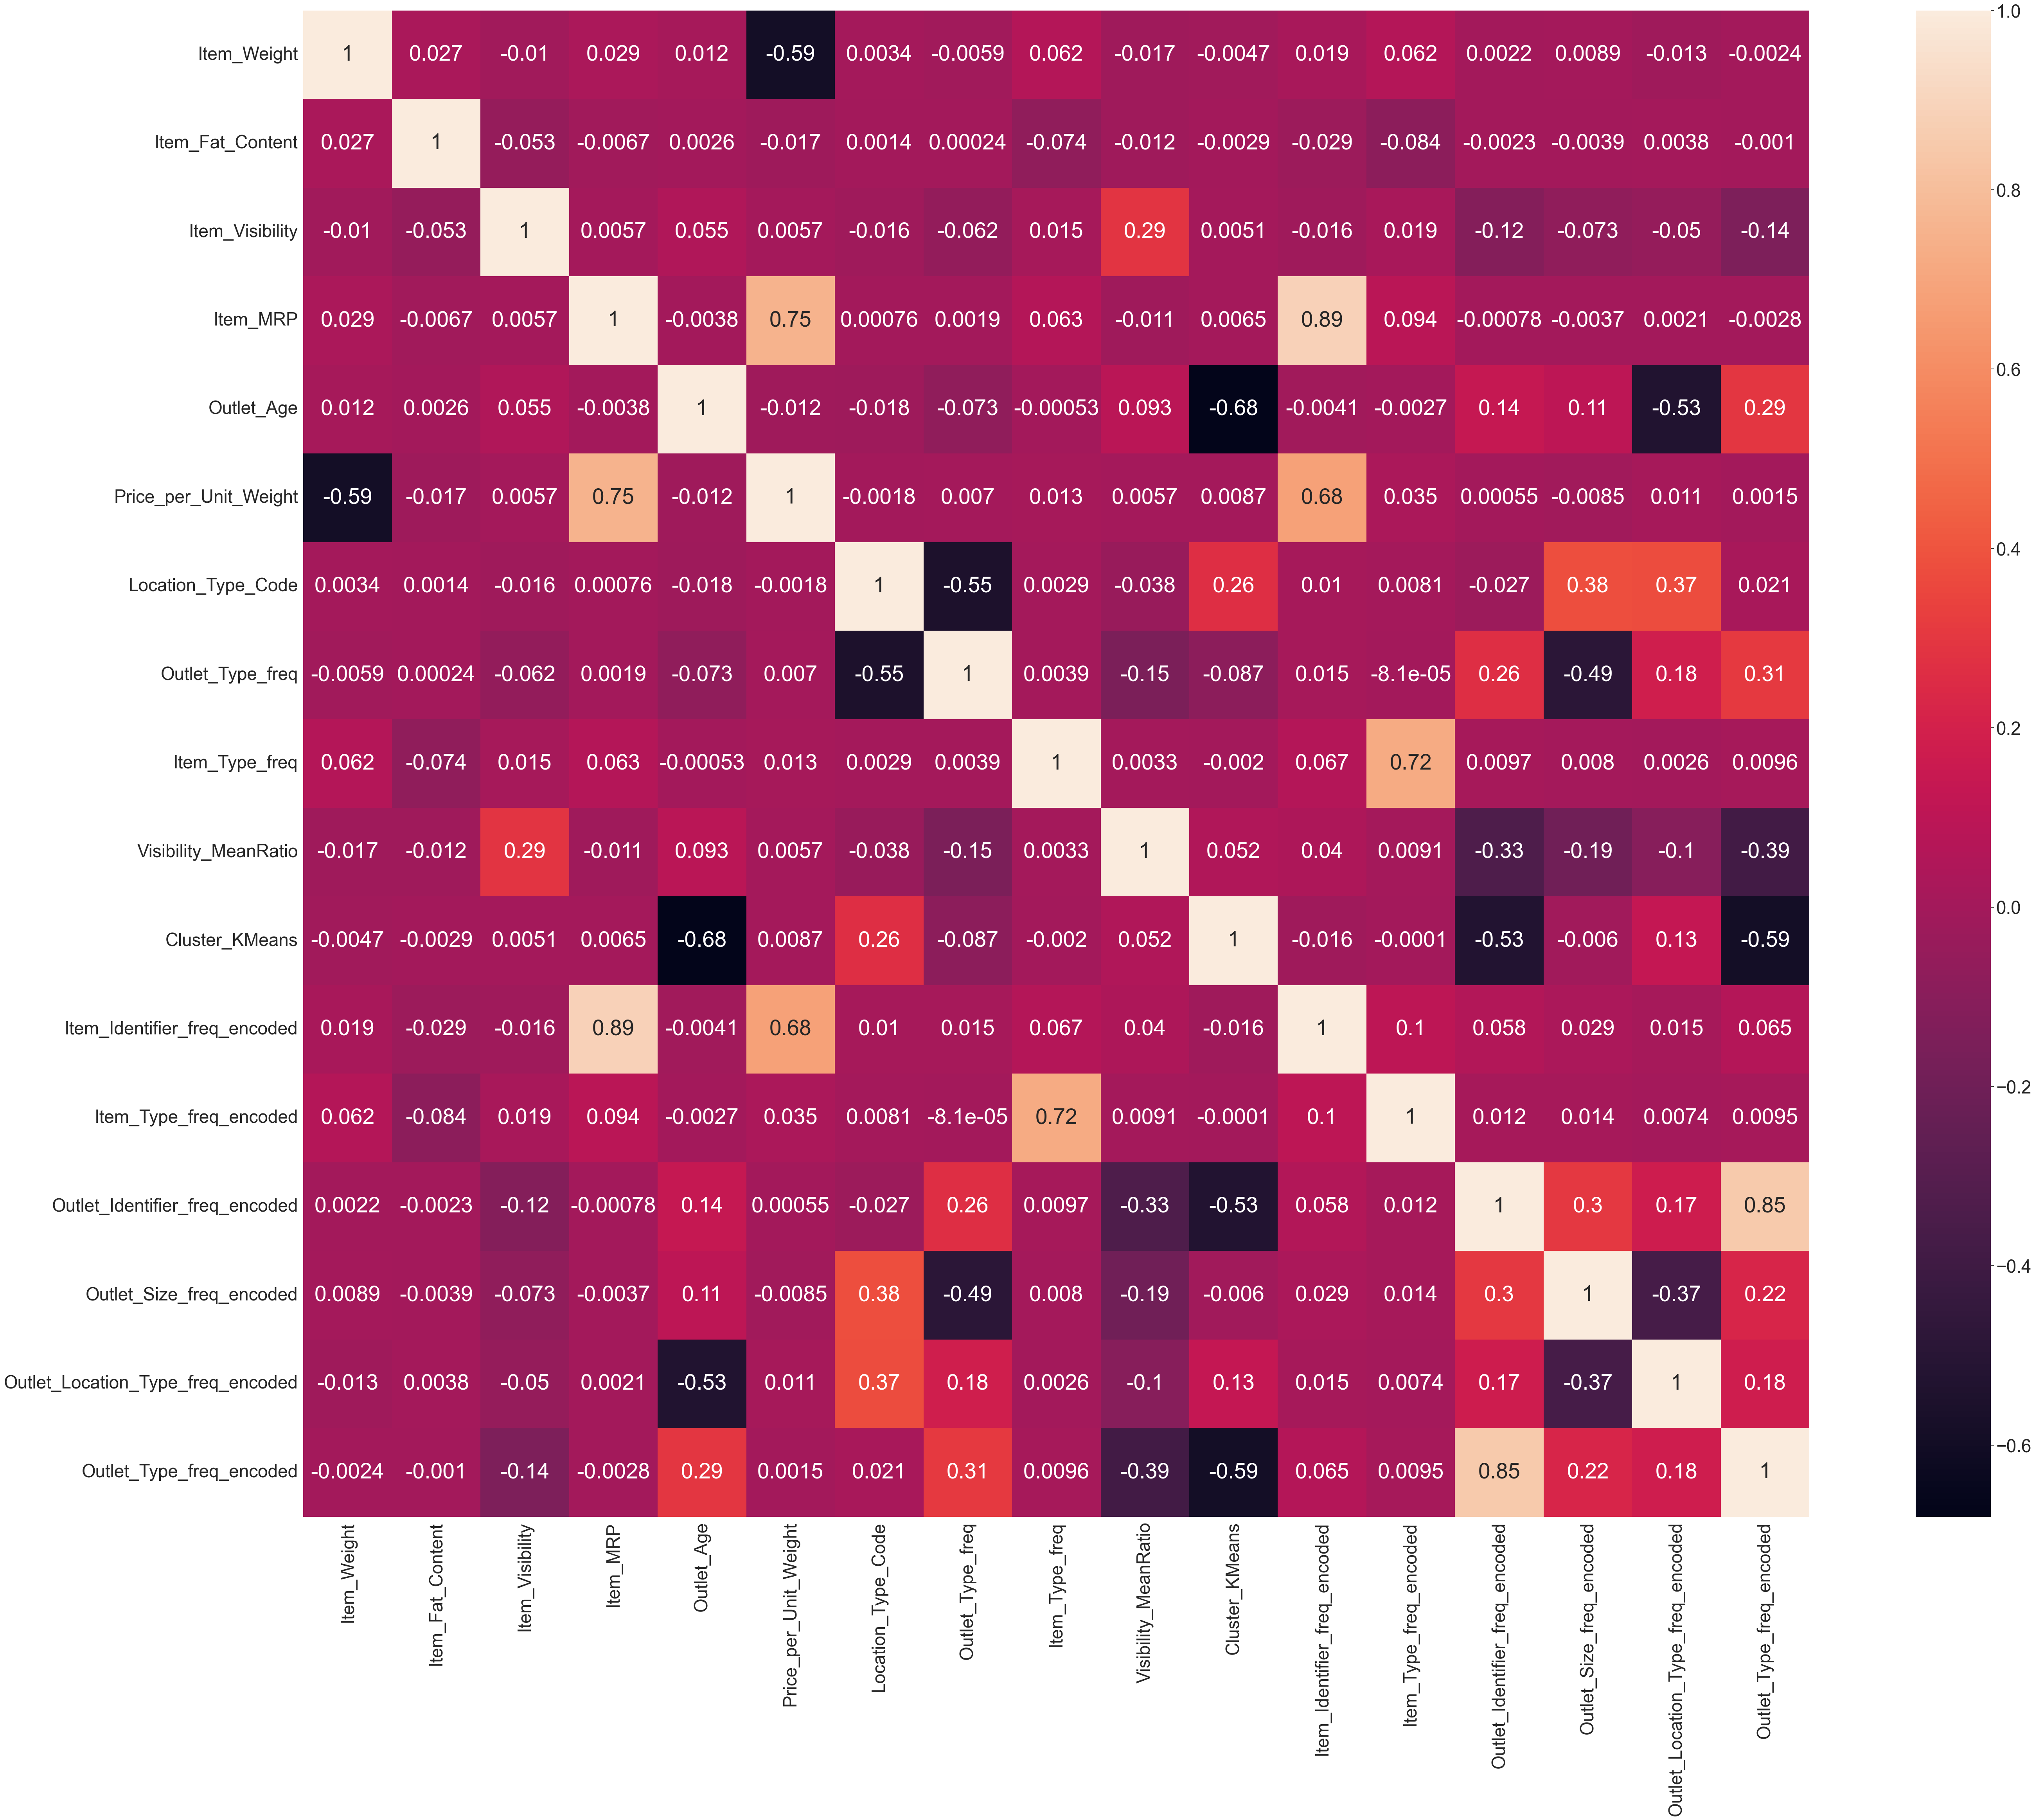

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
#Checking correlation with top 20 significant features
sign_corr_mat=X_train.corr(method='spearman')
plt.figure(figsize=(70,50))
sns.set(font_scale=3)
sns.heatmap(sign_corr_mat,square=True,annot=True,annot_kws={"size": 40})
plt.show()

In [16]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
rfe = RFE(estimator=RandomForestRegressor(n_estimators = 500, random_state=3), n_features_to_select=20, step=1)
rfe.fit(X_train, y_train)
print("Model created for feature Selection")
significant_features = list(set(X_train.columns[rfe.support_]))
feature_importance_values = rfe.estimator_.feature_importances_

/Users/bikrdas/Library/Python/3.10/lib/python/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=20 > n_features=17. There will be no feature selection and all features will be kept.
  warnings.warn(


Model created for feature Selection


In [17]:
significant_feature_df = pd.DataFrame({"feature_name":significant_features,"feature_sign_value":feature_importance_values})
significant_feature_df.sort_values(by='feature_sign_value',inplace = True, ascending = False)
significant_feature_df


,feature_name,feature_sign_value
11,Outlet_Location_Type_freq_encoded,0.456505
13,Item_Fat_Content,0.133048
16,Cluster_KMeans,0.100602
9,Outlet_Identifier_freq_encoded,0.058454
3,Location_Type_Code,0.056872
2,Item_Identifier_freq_encoded,0.044553
5,Item_Weight,0.040676
4,Outlet_Age,0.025185
0,Item_Visibility,0.024185
8,Price_per_Unit_Weight,0.015278


In [33]:
X_train = X_train[significant_features]
test_cleaned_df = test_cleaned_df[significant_features]

In [19]:


# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter grid
param_dist = {
    'n_estimators': randint(500,1000),
    'max_depth': randint(10,60),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9),
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print("Best hyperparameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Get the best estimator
best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bikrdas/Library/Python/3.10/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'max_depth': 10, 'max_features': 0.498117006757994, 'min_samples_leaf': 6, 'min_samples_split': 17, 'n_estimators': 588}
Best score: -1001190.5948185181


In [27]:
test_cleaned_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_binary,Outlet_Age,Price_per_Unit_Weight,Location_Type_Code,Outlet_Type_freq,Item_Type_freq,Visibility_MeanRatio,Cluster_KMeans,Item_Identifier_freq_encoded,Item_Fat_Content_freq_encoded,Item_Type_freq_encoded,Outlet_Identifier_freq_encoded,Outlet_Size_freq_encoded,Outlet_Location_Type_freq_encoded,Outlet_Type_freq_encoded
0,20.750,0.007565,107.8622,1,26,5.198178,1,65.428622,13.888400,1.037214,0,1693.795200,2157.711534,2277.321739,2348.354635,2681.603542,1876.909159,2316.181148
1,8.300,0.038428,87.3198,0,18,10.520458,2,65.428622,7.991551,1.205928,0,1453.663333,2224.561170,2232.542597,2340.675263,1867.182814,2323.990559,2316.181148
2,14.600,0.099575,241.7538,1,27,16.558479,3,12.709030,1.953881,1.434235,1,4470.580680,2157.711534,1926.139702,339.351662,1867.182814,2279.627651,339.828500
3,7.315,0.015388,155.0340,1,18,21.193985,2,65.428622,13.888400,1.005663,2,1658.951667,2157.711534,2277.321739,2340.675263,1867.182814,2323.990559,2316.181148
4,13.600,0.118599,234.2300,0,40,17.222794,3,10.983982,7.991551,0.995396,1,3448.844000,2224.561170,2232.542597,3694.038558,2681.603542,2279.627651,3694.038558


In [37]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the test set
test_df['Item_Outlet_Sales_rf'] = best_rf_model.predict(test_cleaned_df)
final_rf_df = pd.concat([identifiers_test_df, test_df[['Item_Outlet_Sales_rf']]], axis=1) 
final_rf_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_rf
0,FDW58,OUT049,1890.961232
1,FDW14,OUT017,1602.575454
2,NCN55,OUT010,647.217585
3,FDQ58,OUT017,1932.565467
4,FDY38,OUT027,5241.544195


In [38]:
final_rf_df[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_rf']].to_csv('predicted_sales_rf6.csv', index=False)


In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import numpy as np

# 1. Define the model (same as before)
def create_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[X.shape[1]]),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0) # Apply gradient clipping
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
    return model

# 2. Prepare data
X = train_cleaned_df.drop('Item_Outlet_Sales', axis=1).values  # Convert to NumPy array
y = train_cleaned_df['Item_Outlet_Sales'].values  # Convert to NumPy array

# 3. Perform k-fold cross-validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train1, X_val = X[train_index], X[val_index]
    y_train1, y_val = y[train_index], y[val_index]

    model = create_model()  # Create a new model for each fold
    history = model.fit(X_train1, y_train1, epochs=500, batch_size=32, verbose=0)
    
    _, mae = model.evaluate(X_val, y_val, verbose=0)
    scores.append(mse)

# 4. Print results
print(f"Average MSE across {n_splits} folds: {np.mean(scores)}")
final_model = create_model() 
final_model.fit(X, y, epochs=500, batch_size=32, verbose=0)  # Train on all data

Fold 1/5
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=500, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=500, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=700, reg_alpha=5, reg_lambda=2, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_esti

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=500, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=10, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=7

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=900, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=500

NameError: name 'mse' is not defined

KeyError: 'val_loss'

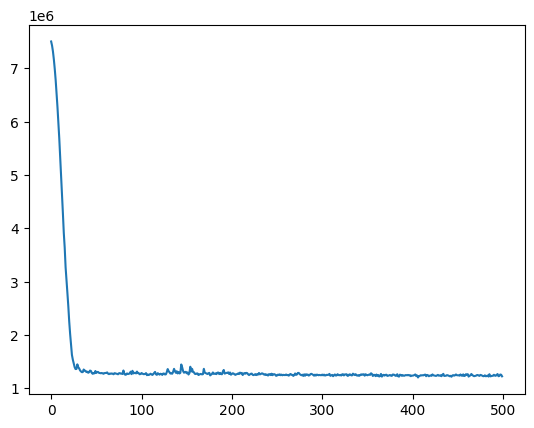

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()

In [47]:
# Predict on the test set
test_df['Item_Outlet_Sales_ANN'] = final_model.predict(test_cleaned_df)
final_df_ann = pd.concat([identifiers_test_df, test_df[['Item_Outlet_Sales_ANN']]], axis=1) 
final_df_ann.head()

178/178 [==============================] - 0s 349us/step


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_ANN
0,FDW58,OUT049,131131.125000
1,FDW14,OUT017,125817.039062
2,NCN55,OUT010,110976.007812
3,FDQ58,OUT017,132650.000000
4,FDY38,OUT027,160953.578125


In [48]:
final_df_ann[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_ANN']].to_csv('predicted_sales_ANN_v1.csv', index=False)

In [94]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Prepare data (assuming you have X and y defined as before)
X = train_cleaned_df.drop('Item_Outlet_Sales', axis=1).values
y = train_cleaned_df['Item_Outlet_Sales'].values

# 1.1 transform the training labels
y_log = np.log1p(y)

# 2. Perform k-fold cross-validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_log[train_index], y_log[val_index]

    # Create and train the XGBoost model for the current fold
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Specify objective for regression
        n_estimators=200,              # Number of boosting rounds (trees)
        learning_rate=0.1,            # Step size shrinkage used in update
        max_depth=3,                  # Maximum depth of a tree
        subsample=0.8,                # Subsample ratio of the training instance
        colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
        random_state=42               # Random seed for reproducibility
    ) 
    xgb_model.fit(X_train, y_train)
    
    # Evaluate on validation set for the current fold
    y_pred = xgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(rmse)

# 3. Print results
print(f"Average RMSE across {n_splits} folds: {np.mean(scores)}")

 
final_xgb_model = xgb_model.fit(X, y_log)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average RMSE across 5 folds: 0.522628589031174


In [23]:
# 5. Predict on test set and create final_df
test_df['Item_Outlet_Sales_xgb'] = final_xgb_model.predict(test_cleaned_df)
test_df['Item_Outlet_Sales_xgb_inverse'] = np.expm1(test_df['Item_Outlet_Sales_xgb'])
final_df_xgb = pd.concat([identifiers_test_df, test_df[['Item_Outlet_Sales_xgb','Item_Outlet_Sales_xgb_inverse']]], axis=1) 
final_df_xgb.head()


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_xgb,Item_Outlet_Sales_xgb_inverse
0,FDW58,OUT049,7.431276,1686.959717
1,FDW14,OUT017,7.143691,1265.092407
2,NCN55,OUT010,6.229955,506.732727
3,FDQ58,OUT017,7.712470,2235.057617
4,FDY38,OUT027,8.649606,5706.895996


In [24]:
final_df_xgb[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_xgb_inverse']].to_csv('predicted_sales_xgb.csv', index=False)


In [93]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Prepare data (assuming you have X and y defined as before)
X = train_cleaned_df.drop('Item_Outlet_Sales', axis=1).values
y = train_cleaned_df['Item_Outlet_Sales'].values


# 2. Perform k-fold cross-validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create and train the XGBoost model for the current fold
    xgb_model = xgb.XGBRegressor(
        objective='reg:tweedie',  # Specify objective for regression
        n_estimators=300,              # Number of boosting rounds (trees)
        learning_rate=0.1,            # Step size shrinkage used in update
        tweedie_variance_power=1.5,
        max_depth=3,                  # Maximum depth of a tree
        subsample=0.8,                # Subsample ratio of the training instance
        colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
        random_state=42               # Random seed for reproducibility
    ) 
    xgb_model.fit(X_train, y_train)
    
    # Evaluate on validation set for the current fold
    y_pred = xgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(rmse)

# 3. Print results
print(f"Average RMSE across {n_splits} folds: {np.mean(scores)}")

 
final_xgb_model = xgb_model.fit(X, y)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average RMSE across 5 folds: 1097.2669840819103


In [30]:
# 5. Predict on test set and create final_df
test_df['Item_Outlet_Sales_xgb'] = final_xgb_model.predict(test_cleaned_df)
final_df_xgb = pd.concat([identifiers_test_df, test_df[['Item_Outlet_Sales_xgb']]], axis=1) 
final_df_xgb.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_xgb
0,FDW58,OUT049,1858.765747
1,FDW14,OUT017,1354.819946
2,NCN55,OUT010,561.794556
3,FDQ58,OUT017,2485.334229
4,FDY38,OUT027,5947.942871


In [31]:
final_df_xgb[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_xgb']].to_csv('predicted_sales_xgb3.csv', index=False)


In [41]:

from sklearn.model_selection import KFold, RandomizedSearchCV
import xgboost as xgb
# 1. Prepare data
X = X_train.values
y = y_train.values

train_cleaned_df['Item_Outlet_Sales']

# 2. Define KFold for use inside RandomizedSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Specify hyperparameter search space
param_distributions = {
    'n_estimators':        [300,400,500,700,900],
    'learning_rate':       [0.01, 0.05, 0.1, 0.2],
    'max_depth':           [3, 4, 5, 6],
    'subsample':           [0.8, 0.9, 1.0],
    'colsample_bytree':    [0.8, 0.9, 1.0],
    'gamma':               [0, 0.5, 1, 5],
    'reg_alpha':           [0, 0.5, 1, 5],
    'reg_lambda':          [1, 2, 5, 10],
#     'tweedie_variance_power': [1.1, 1.5, 1.9]  # only used if objective='reg:tweedie'
}

# 4. Instantiate the base regressor
xgb_base = xgb.XGBRegressor(
    objective='reg:gamma',
    random_state=42,
    n_jobs=-1
)

# 5. Wrap in RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=100,                       # number of random draws
    scoring='neg_mean_squared_error',
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 6. Execute the search
rand_search.fit(X, y)

# 7. Inspect best hyperparameters and CV score
print("Best parameters found:", rand_search.best_params_)
best_rmse = np.sqrt(-rand_search.best_score_)
print(f"Best CV RMSE: {best_rmse:.4f}")

# 8. Retrain on full data with best estimator
best_model = rand_search.best_estimator_
best_model.fit(X, y)

# # 9. Predict on test set and clip negatives
# raw_preds = best_model.predict(test_cleaned_df.values)
# test_df['Item_Outlet_Sales_xgb'] = np.clip(raw_preds, a_min=0, a_max=None)

print("Finished training and prediction—negative values clipped to zero.")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}
Best CV RMSE: 976.8059
Finished training and prediction—negative values clipped to zero.


In [64]:
len(X[1])

12

In [42]:
# 5. Predict on test set and create final_df
test_df['Item_Outlet_Sales_xgb'] = best_model.predict(test_cleaned_df)
final_df_xgb = pd.concat([identifiers_test_df, test_df[['Item_Outlet_Sales_xgb']]], axis=1) 
final_df_xgb.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_xgb
0,FDW58,OUT049,1859.083130
1,FDW14,OUT017,1561.104614
2,NCN55,OUT010,629.156067
3,FDQ58,OUT017,1723.259766
4,FDY38,OUT027,4353.106445


In [43]:

final_df_xgb[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_xgb']].to_csv('predicted_sales_xgb9.csv', index=False)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=500, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=10, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=9

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=500, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=10, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=500, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=10, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.1, max_depth=5, n_estimators=400, reg_alpha=5, reg_lambda=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=900, reg_alpha=0.5, reg_lambda=5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=5, n_estimator

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=900, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, n_estimators=900, reg_alpha=5, reg_lambda=10, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.2, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=400, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=5, learning_rate=0.05, max_depth=6, n_estimators

5. Ensembling for a Final Push

In [26]:
# Simple average
final_df_xgb['Item_Outlet_Sales_ensemble_preds'] = 0.5 * final_rf_df['Item_Outlet_Sales_rf'] + 0.5 * final_df_xgb['Item_Outlet_Sales_xgb']
final_df_xgb.head()


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_xgb,Item_Outlet_Sales_ensemble_preds
0,FDW58,OUT049,1773.447998,1817.350060
1,FDW14,OUT017,1489.195312,1547.453455
2,NCN55,OUT010,631.423950,708.592520
3,FDQ58,OUT017,1707.619141,1824.020893
4,FDY38,OUT027,5294.742188,5267.556369


In [27]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales_rf,Item_Outlet_Sales_xgb
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1861.252122,1773.447998
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,1605.711598,1489.195312
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,785.761090,631.423950
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,1940.422645,1707.619141
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,5240.370551,5294.742188


In [28]:
final_df_xgb[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_ensemble_preds']].to_csv('predicted_sales_ensemble_xgb9.csv', index=False)



In [73]:
# Simple average
final_df_xgb['Item_Outlet_Sales_ensemble_preds'] = 0.3 * final_rf_df['Item_Outlet_Sales_rf'] + 0.7 * final_df_xgb['Item_Outlet_Sales_xgb']
final_df_xgb[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_ensemble_preds']].to_csv('predicted_sales_ensemble_xgb8.csv', index=False)

final_df_xgb.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales_xgb,Item_Outlet_Sales_ensemble_preds
0,FDW58,OUT049,1775.959595,1781.628880
1,FDW14,OUT017,1388.703003,1393.555957
2,NCN55,OUT010,594.603699,600.034709
3,FDQ58,OUT017,2477.653564,2419.145425
4,FDY38,OUT027,5781.984863,5773.356542
